# 2kr Assumptions Tests (Low Density Scenario)

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'data.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['T', 'm', 'D', 'R']

# Fitting
distsFit = ['norm'] # Distributions to fit
distsParams = [()] # Distributions params
outlierStddevDistance = 3 # Outliers identification

# Plots
histBinNum = 30 # Histograms
histCenter = True # Center distribution
plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
scatterShowLines = False
# Save
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

# Residuals to compute
residualNames = [
    ('coveredUsersPercent', 'percentage of covered users (residuals)'),
    ('collisions', 'total number of collisions (residuals)'),
    ('msgsPerSlot', 'total number of messages sent (residuals)'),
]

# Transformations
transformations = [
]

intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for i, d in vecPerfIndexes:
    residualNames.append((i, d + ' (residuals)'))
    transformations.append((i, lambda x: math.log(x)))

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

# Scatter plot whitelists
configsShown = range(0, configsCount)
repetitionsShown = range(0, repetitionsCount)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## Apply transformations

In [8]:
for col, transform in transformations:
    scalars_wide[col] = scalars_wide[col].map(transform, 'ignore')

## Compute residuals

In [9]:
# coverage
scalars_wide['coveredUsersPercentMean'] = scalars_wide.groupby(factors)['coveredUsersPercent'].transform('mean')
scalars_wide['coveredUsersPercentResidual'] = scalars_wide['coveredUsersPercent'] - scalars_wide['coveredUsersPercentMean']

# collisions
scalars_wide['collisionsMean'] = scalars_wide.groupby(factors)['Floorplan.collisions:sum'].transform('mean')
scalars_wide['collisionsResidual'] = scalars_wide['Floorplan.collisions:sum'] - scalars_wide['collisionsMean']

# msgsPerSlot
scalars_wide['msgsPerSlotMean'] = scalars_wide.groupby(factors)['Floorplan.msgsPerSlot:sum'].transform('mean')
scalars_wide['msgsPerSlotResidual'] = scalars_wide['Floorplan.msgsPerSlot:sum'] - scalars_wide['msgsPerSlotMean']

# vectors
skipped = []
for vecPerfIndex, _ in vecPerfIndexes:
    mean = scalars_wide.groupby(factors)[vecPerfIndex].transform('mean')
    nextVect = False
    for value in mean.values:
        if math.isinf(value):
            skipped.append(vecPerfIndex)
            nextVect = True
            continue
    if nextVect:
        continue
    scalars_wide[vecPerfIndex + 'Mean'] = mean
    scalars_wide[vecPerfIndex + 'Residual'] = scalars_wide[vecPerfIndex] - scalars_wide[vecPerfIndex + 'Mean']
for i, d in vecPerfIndexes:
    if i not in skipped:
        continue
    print(i + ' skipped due to infinite values in observations')
    residualNames.remove((i, d + ' (residuals)'))

## Residual distributions (histograms)

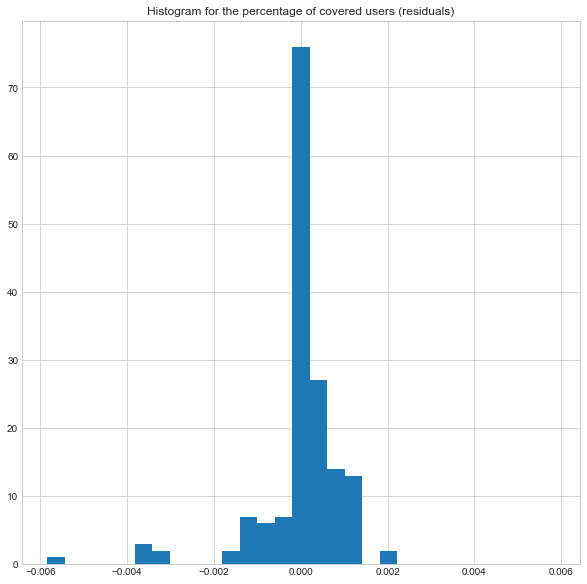

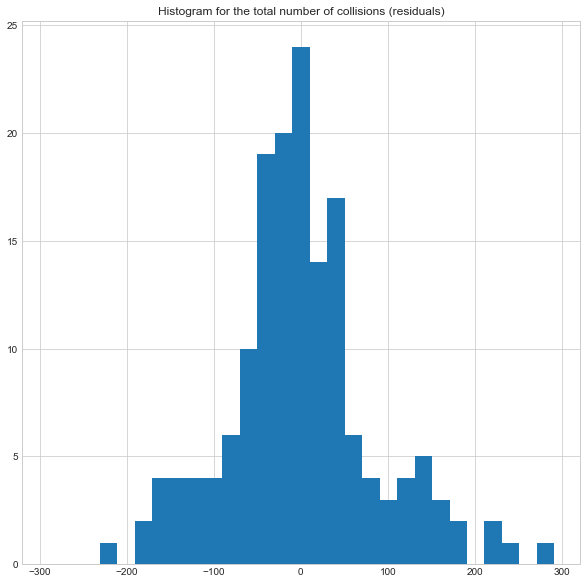

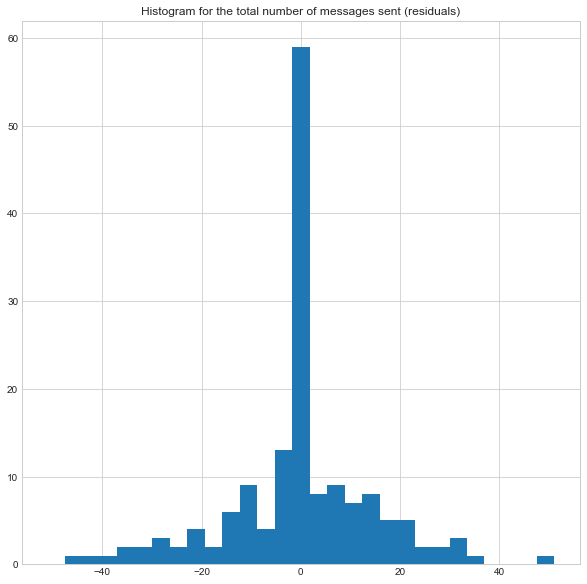

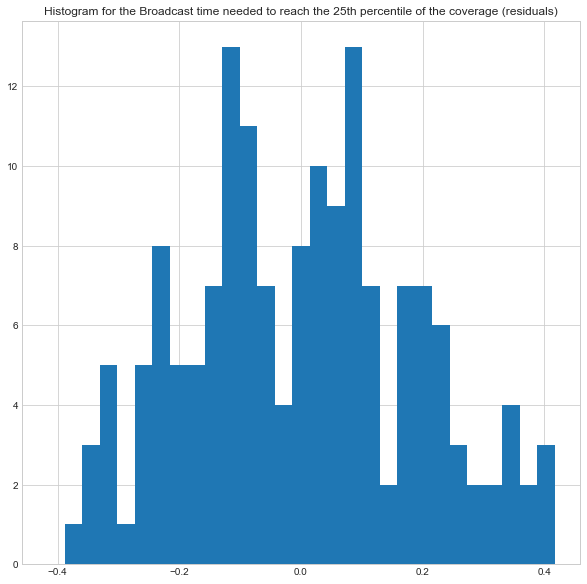

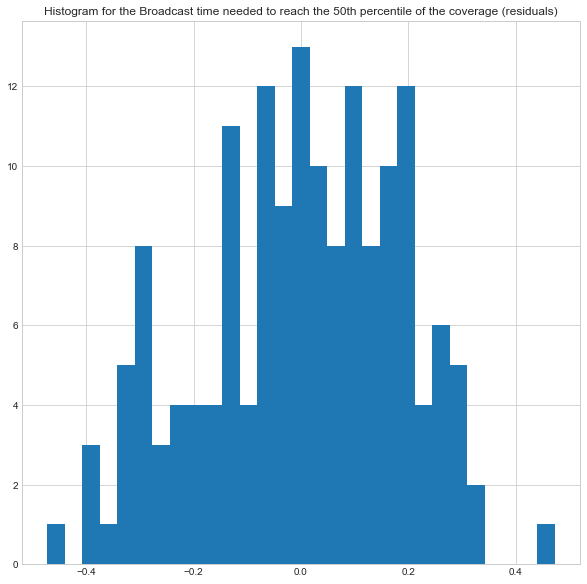

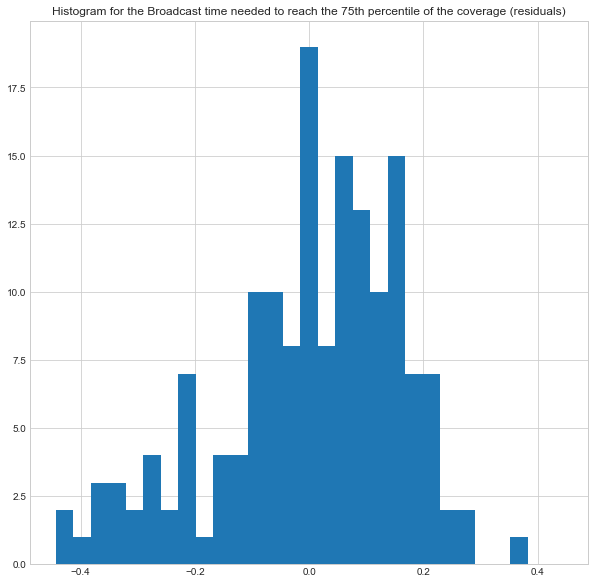

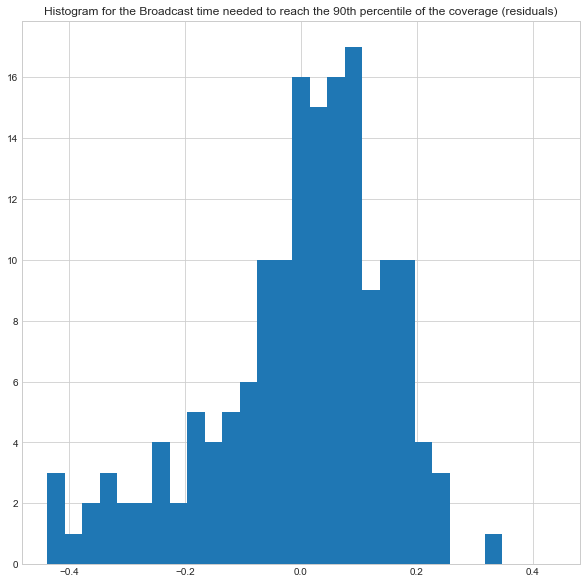

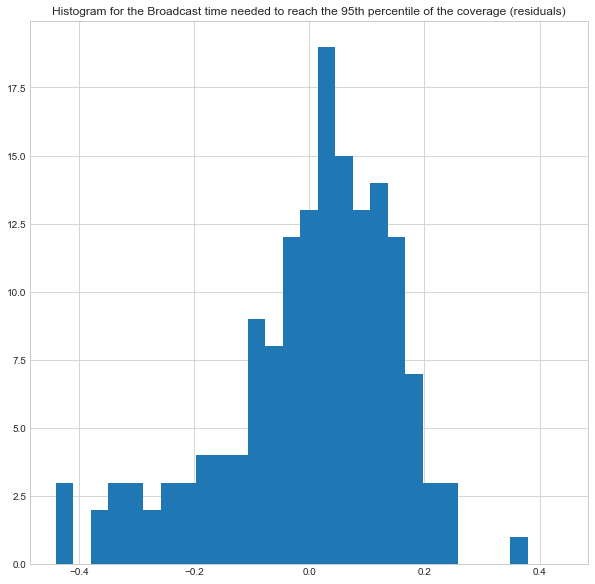

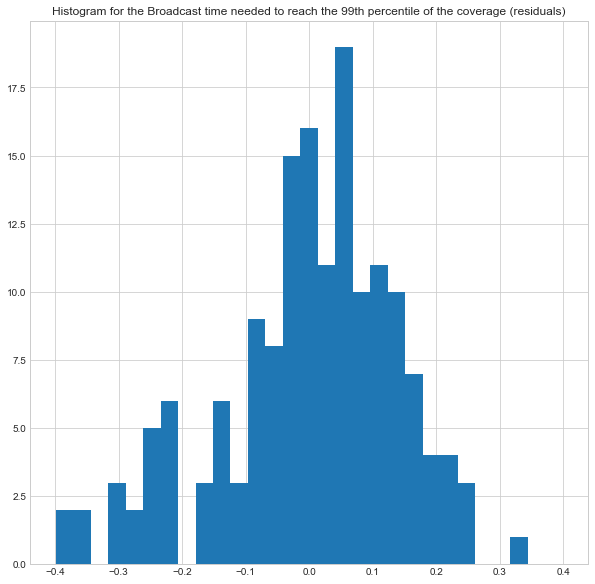

In [10]:
for varname, vardesc in residualNames:
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    minval = scalars_wide[varname + 'Residual'].min()
    maxval = scalars_wide[varname + 'Residual'].max()
    if histCenter:
        limit = max(abs(minval), abs(maxval))
        minval = -limit
        maxval = limit
    plt.hist(scalars_wide[varname + 'Residual'].values.tolist(), bins=np.linspace(minval, maxval, histBinNum))
    plt.title('Histogram for the ' + vardesc)
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-hist.png')
    plt.show()

### Notes on distributions

We can see from histograms that, for all indexes except the percentage of covered users, the distribution of the residuals seems normal. The percentage of covered user has a tail on the left.

## Distribution fitting

Trying to fit to a norm distribution:


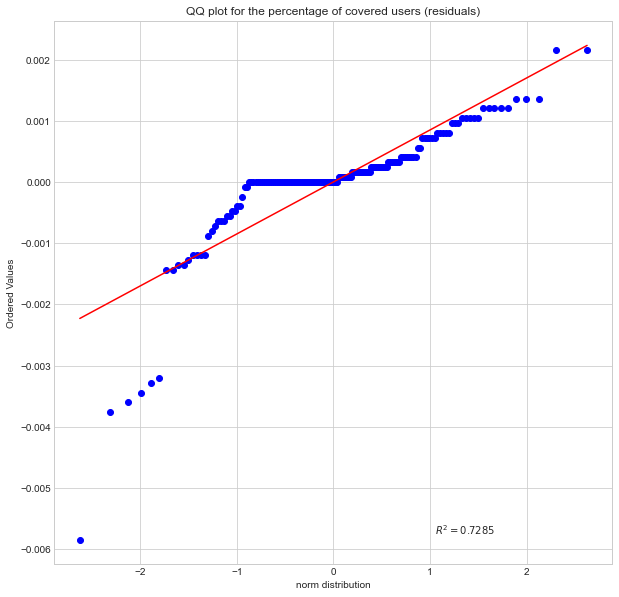

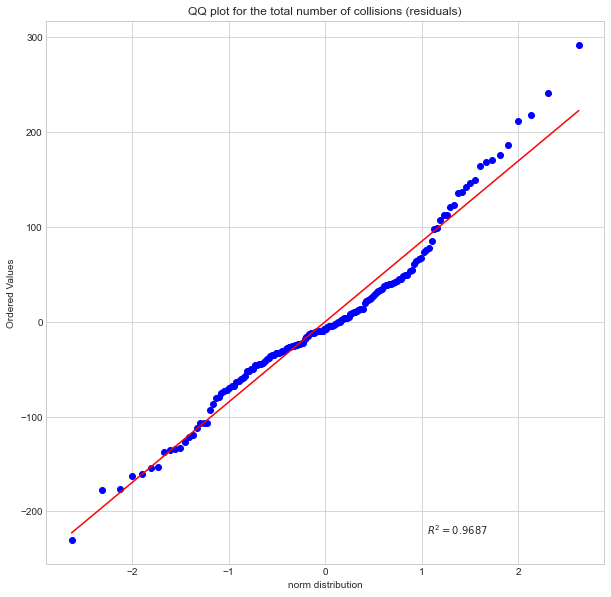

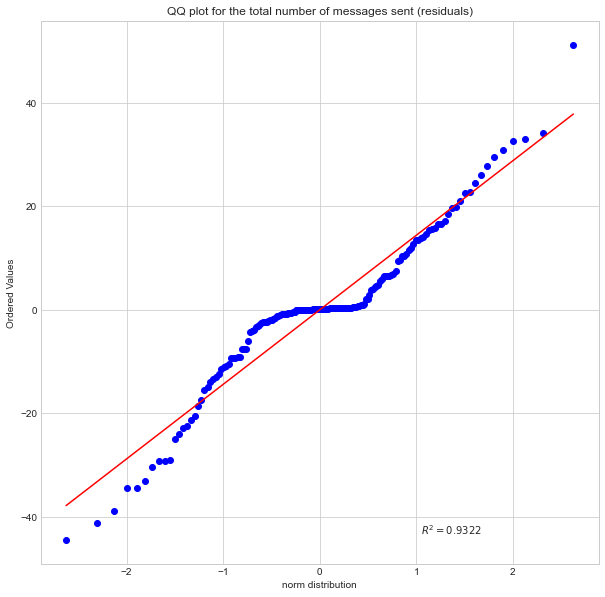

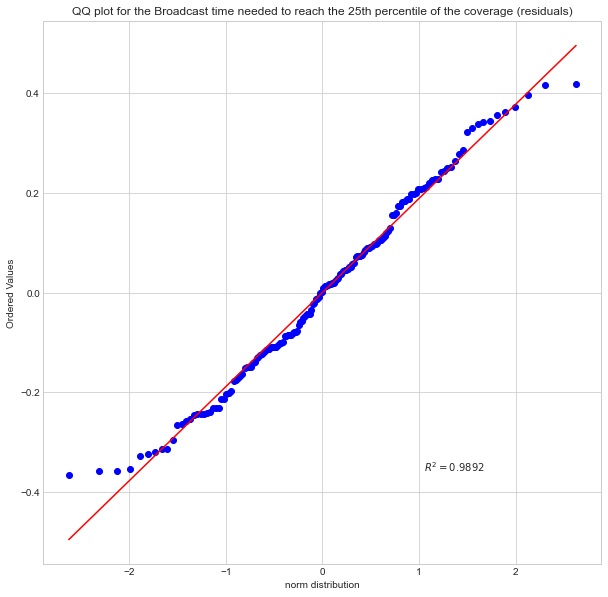

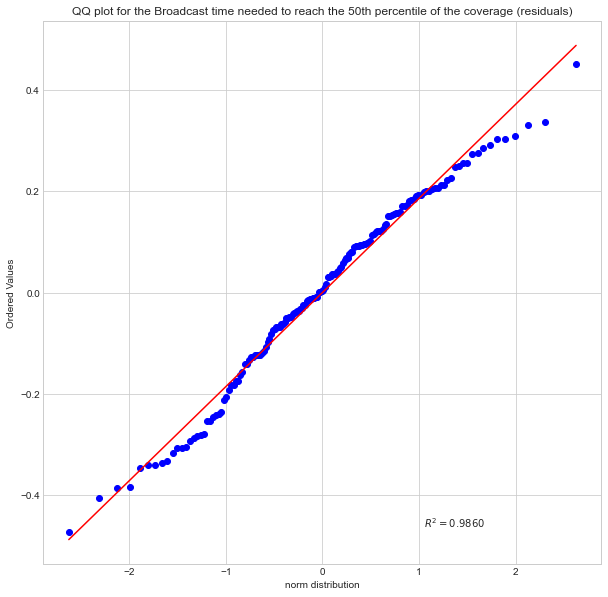

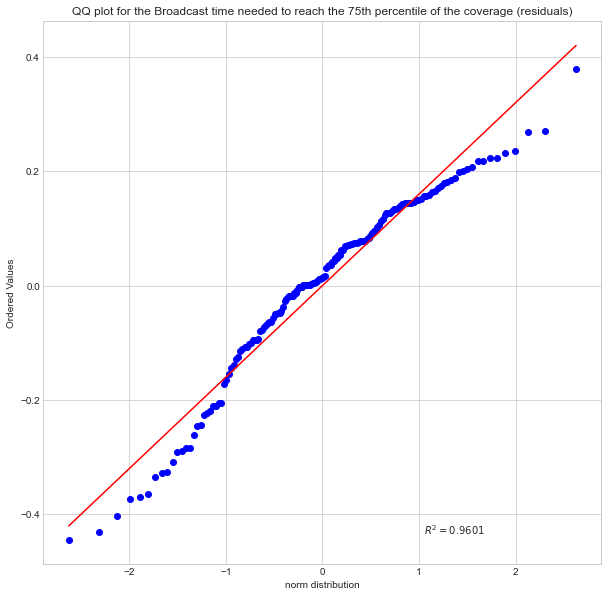

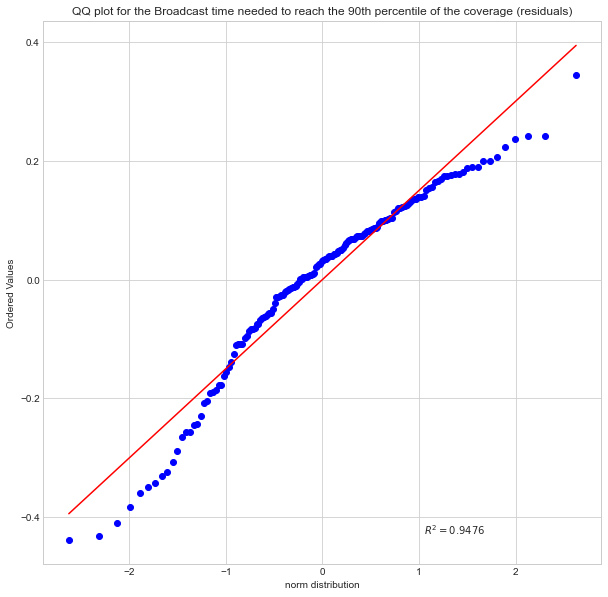

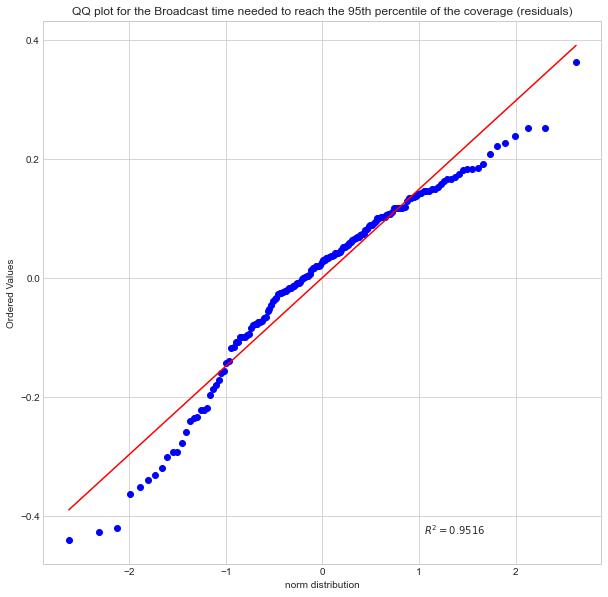

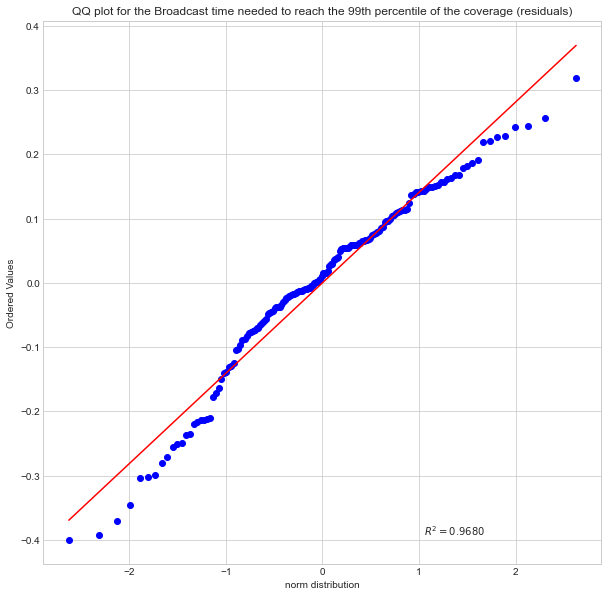

In [11]:
for distribution, params in zip(distsFit, distsParams):
    print('Trying to fit to a', distribution + ('({})'.format(', '.join(map(str, params))) if len(params) > 0 else ''), 'distribution:')
    for varname, vardesc in residualNames:
        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        residuals = scalars_wide[varname + 'Residual'].values.tolist()
        result, line = stats.probplot(residuals, dist=distribution, sparams=params, plot=plt, rvalue=True)
        #osm, _ = result
        #slope, intercept, _ = line
        plt.title("QQ plot for the " + vardesc)
        plt.xlabel(distribution + " distribution")
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(varname) + '-' + distribution + '-fit.png')
        plt.show()

### Notes on QQ plots

For all the indexes, except the percentage of covered users, we get "good" QQ-plots that signal a normal distribution of the residuals. The lowest R^2 index is given by the residuals of the total number of messages sent (R^2 = 0.9322). We get this result mainly due to one outlier on the right.

As in the high density scenario the percentage of covered users will not be studied in the continue of this experiments, because it is still perfect in all the cases. There will be a new different study for this index

### Outliers

In [12]:
for varname, vardesc in residualNames:
    print('Outliers for the ' + vardesc)
    stddev = scalars_wide[varname + 'Residual'].std()
    limit = outlierStddevDistance*stddev
    print('total mean:', scalars_wide[varname + 'Mean'].mean())
    print('stddev:', stddev)
    print(str(outlierStddevDistance) + '*stddev:', limit)
    outliers = scalars_wide[np.abs(scalars_wide[varname + 'Residual']) > limit]
    display(outliers[['config', 'repetition', *factors, varname + 'Residual', varname + 'Mean']])

Outliers for the percentage of covered users (residuals)
total mean: 0.9994945956765413
stddev: 0.0009850925726315608
3*stddev: 0.002955277717894682


qname,config,repetition,T,m,D,R,coveredUsersPercentResidual,coveredUsersPercentMean
run,,,,,,,,
LowDensity2kr-5-20210527-19:28:43-6528,0.0,5.0,5.0,2.0,5.0,30.0,-0.003603,0.998799
LowDensity2kr-42-20210527-19:29:56-6645,2.0,2.0,5.0,2.0,10.0,30.0,-0.003283,0.999279
LowDensity2kr-80-20210527-19:30:33-6791,8.0,0.0,10.0,2.0,5.0,30.0,-0.003443,0.997838
LowDensity2kr-82-20210527-19:30:55-6791,8.0,2.0,10.0,2.0,5.0,30.0,-0.005845,0.997838
LowDensity2kr-90-20210527-19:30:34-6797,9.0,0.0,10.0,2.0,5.0,50.0,-0.003763,0.998959
LowDensity2kr-104-20210527-19:32:21-6920,12.0,4.0,10.0,6.0,5.0,30.0,-0.003203,0.999199


Outliers for the total number of collisions (residuals)
total mean: 1446.425
stddev: 85.28806533185235
3*stddev: 255.86419599555705


qname,config,repetition,T,m,D,R,collisionsResidual,collisionsMean
run,,,,,,,,
LowDensity2kr-119-20210527-19:32:34-6962,13.0,9.0,10.0,6.0,5.0,50.0,291.4,3660.6


Outliers for the total number of messages sent (residuals)
total mean: 985.43125
stddev: 14.769018226377446
3*stddev: 44.307054679132335


qname,config,repetition,T,m,D,R,msgsPerSlotResidual,msgsPerSlotMean
run,,,,,,,,
LowDensity2kr-19-20210527-19:29:21-6530,1.0,9.0,5.0,2.0,5.0,50.0,51.1,684.9
LowDensity2kr-138-20210527-19:31:56-6974,11.0,8.0,10.0,2.0,10.0,50.0,-44.4,499.4


Outliers for the Broadcast time needed to reach the 25th percentile of the coverage (residuals)
total mean: 3.9373498898839956
stddev: 0.1875402623900276
3*stddev: 0.5626207871700828


qname,config,repetition,T,m,D,R,broadcastTime25Residual,broadcastTime25Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 50th percentile of the coverage (residuals)
total mean: 4.40852636506275
stddev: 0.18537433543032203
3*stddev: 0.5561230062909661


qname,config,repetition,T,m,D,R,broadcastTime50Residual,broadcastTime50Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 75th percentile of the coverage (residuals)
total mean: 4.70447852695565
stddev: 0.1616075737975318
3*stddev: 0.4848227213925954


qname,config,repetition,T,m,D,R,broadcastTime75Residual,broadcastTime75Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 90th percentile of the coverage (residuals)
total mean: 4.868486292311283
stddev: 0.152552375002145
3*stddev: 0.45765712500643496


qname,config,repetition,T,m,D,R,broadcastTime90Residual,broadcastTime90Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 95th percentile of the coverage (residuals)
total mean: 4.940131383764406
stddev: 0.15084347574182355
3*stddev: 0.45253042722547066


qname,config,repetition,T,m,D,R,broadcastTime95Residual,broadcastTime95Mean
run,,,,,,,,


Outliers for the Broadcast time needed to reach the 99th percentile of the coverage (residuals)
total mean: 5.046451452626973
stddev: 0.14147348069576238
3*stddev: 0.42442044208728713


qname,config,repetition,T,m,D,R,broadcastTime99Residual,broadcastTime99Mean
run,,,,,,,,


## Independency test

qname,config,T,m,D,R
run,,,,,
LowDensity2kr-0-20210527-19:28:43-6527,0.0,5.0,2.0,5.0,30.0
LowDensity2kr-10-20210527-19:28:43-6529,1.0,5.0,2.0,5.0,50.0
LowDensity2kr-40-20210527-19:29:30-6645,2.0,5.0,2.0,10.0,30.0
LowDensity2kr-50-20210527-19:29:44-6676,3.0,5.0,2.0,10.0,50.0
LowDensity2kr-20-20210527-19:28:43-6531,4.0,5.0,6.0,5.0,30.0
LowDensity2kr-30-20210527-19:28:43-6533,5.0,5.0,6.0,5.0,50.0
LowDensity2kr-60-20210527-19:30:08-6725,6.0,5.0,6.0,10.0,30.0
LowDensity2kr-70-20210527-19:30:09-6729,7.0,5.0,6.0,10.0,50.0
LowDensity2kr-80-20210527-19:30:33-6791,8.0,10.0,2.0,5.0,30.0


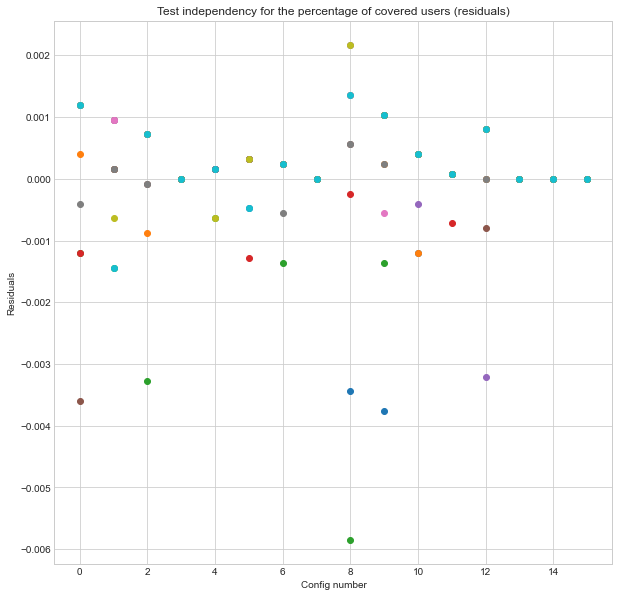

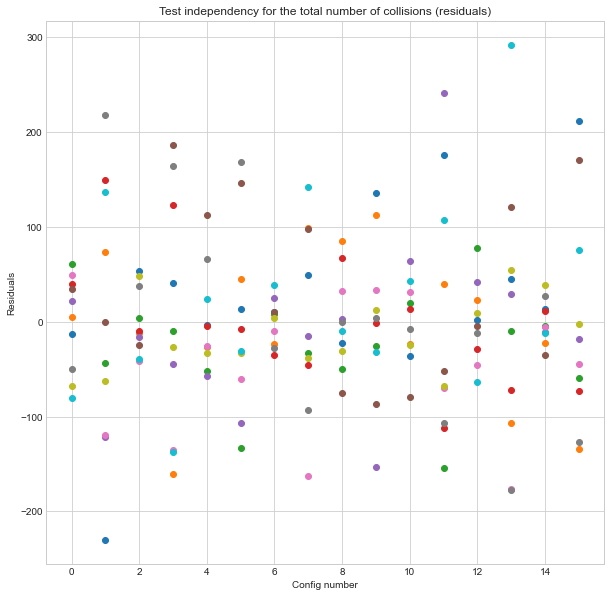

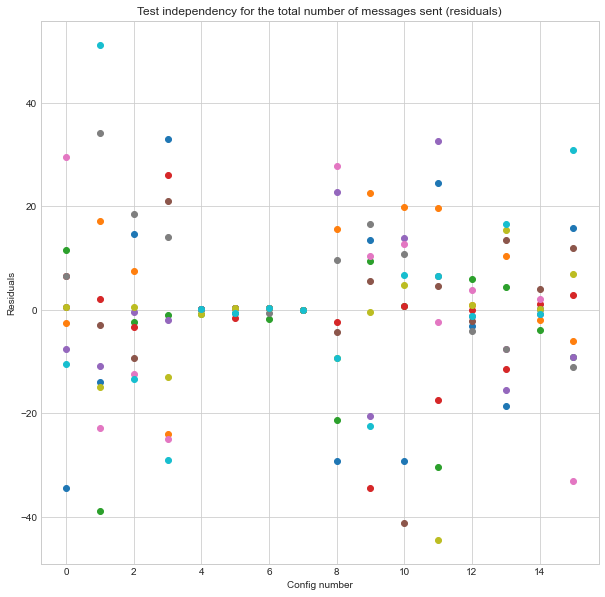

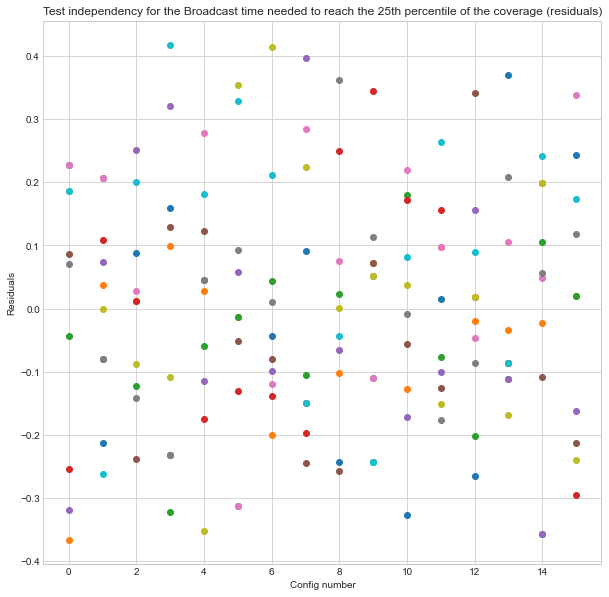

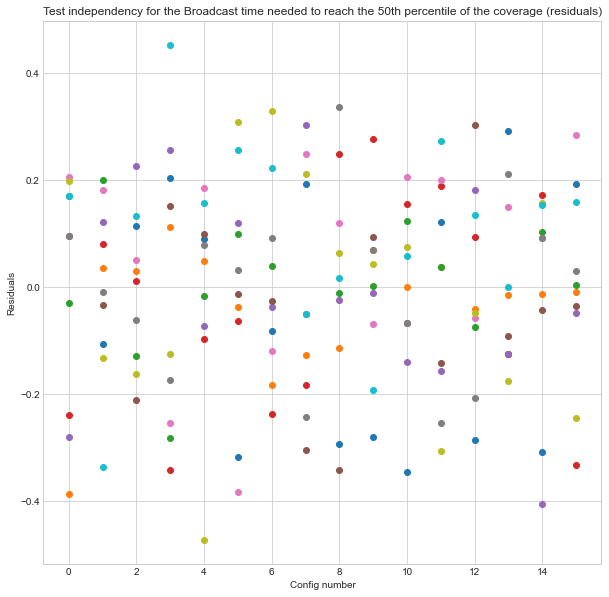

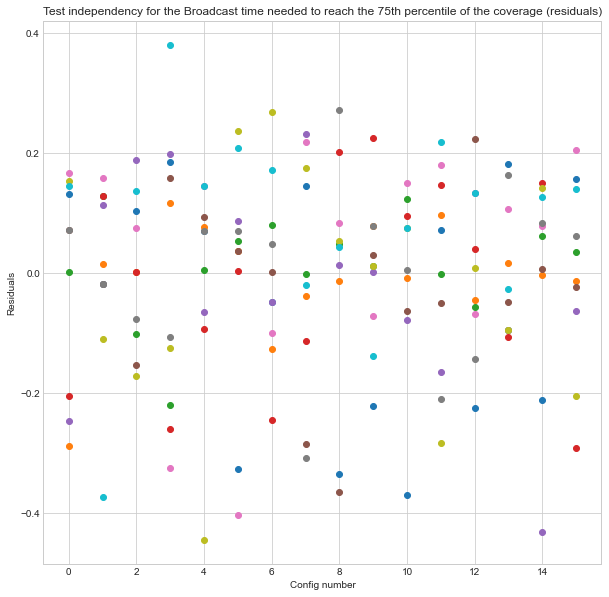

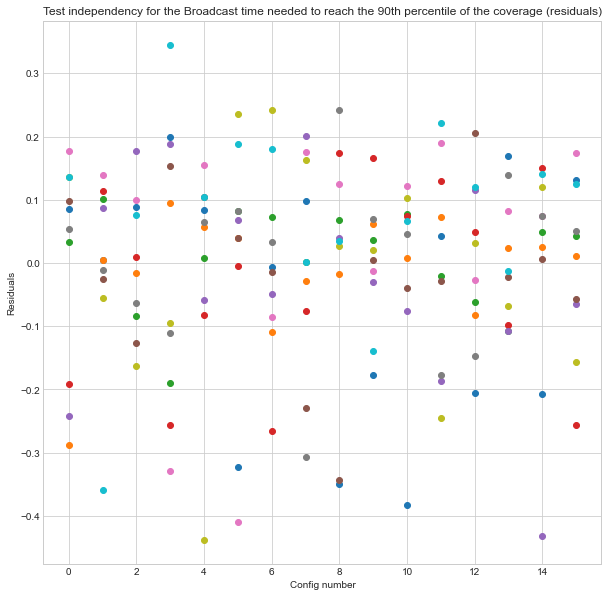

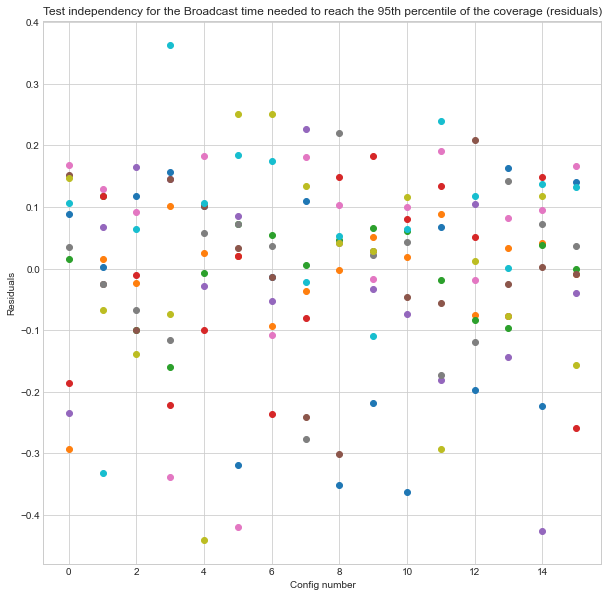

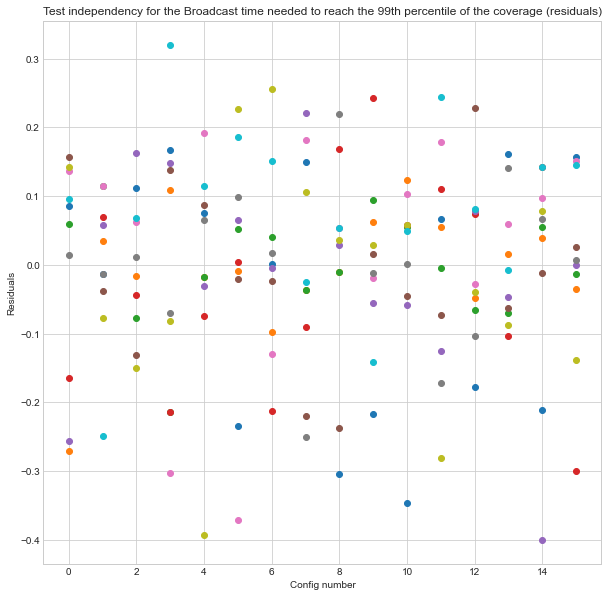

In [13]:
display(scalars_wide.loc[(scalars_wide.repetition == 0) & (scalars_wide.config.isin(configsShown))][['config', *factors]])
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append([config] * len(repetitionsShown))
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test independency for the " + vardesc)
    plt.xlabel("Config number")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-independency.png')
    plt.show()

### Notes on indipendency test

No trend is visible. We expected this result as there is no suspect of dependency between experiments by the way we have conducted the experiments.

(percentage of covered users ignored)

## Finite variance test

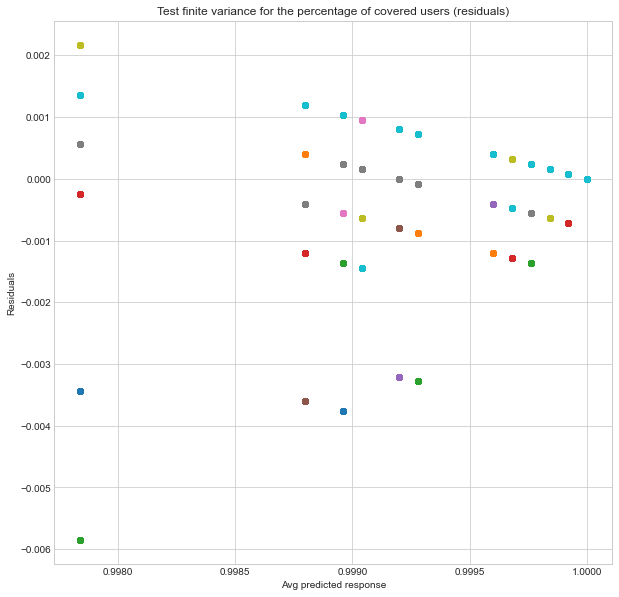

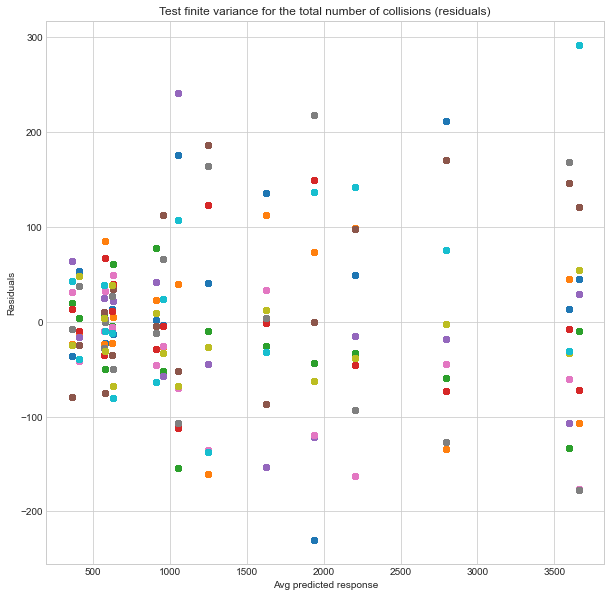

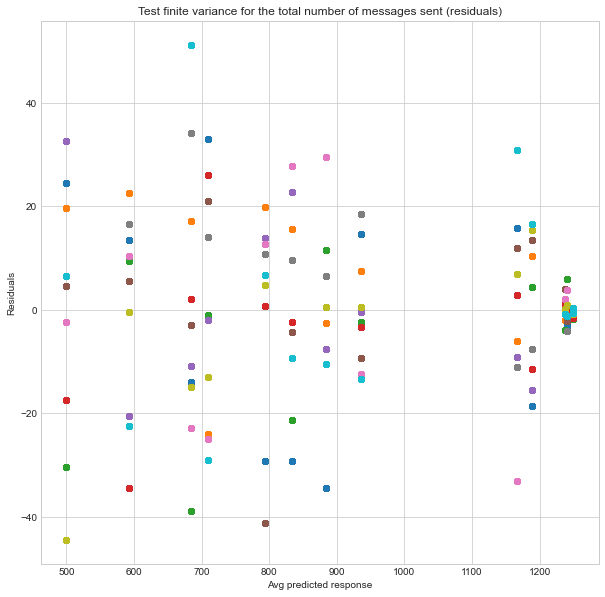

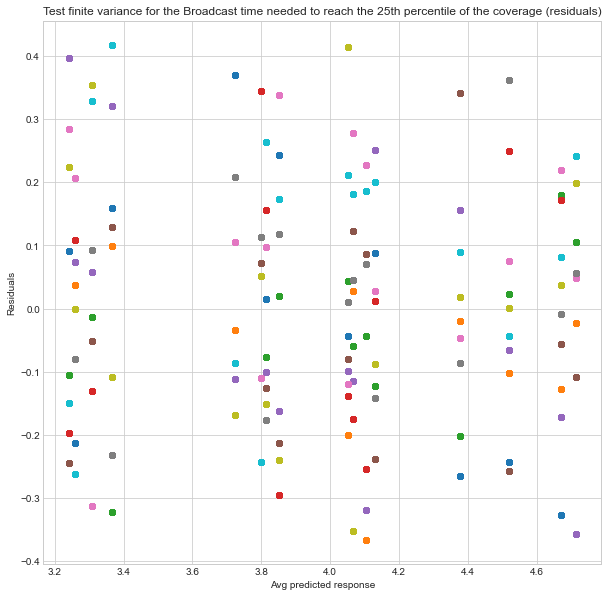

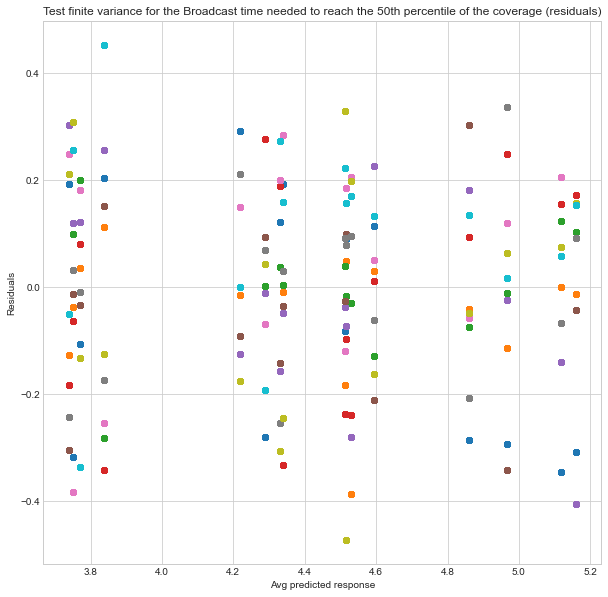

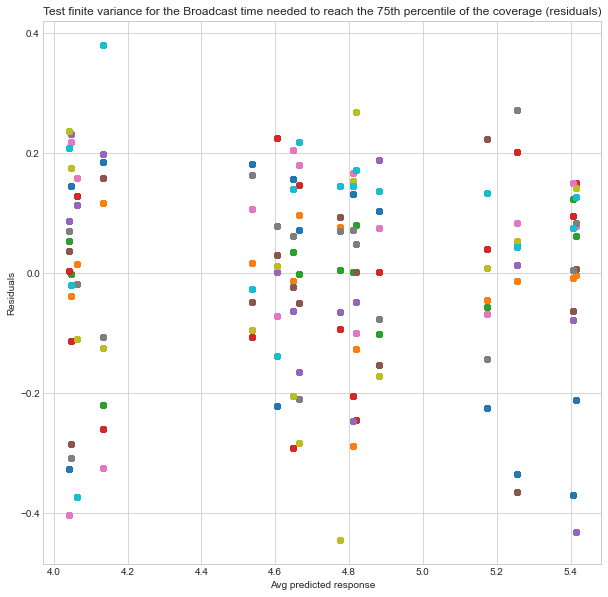

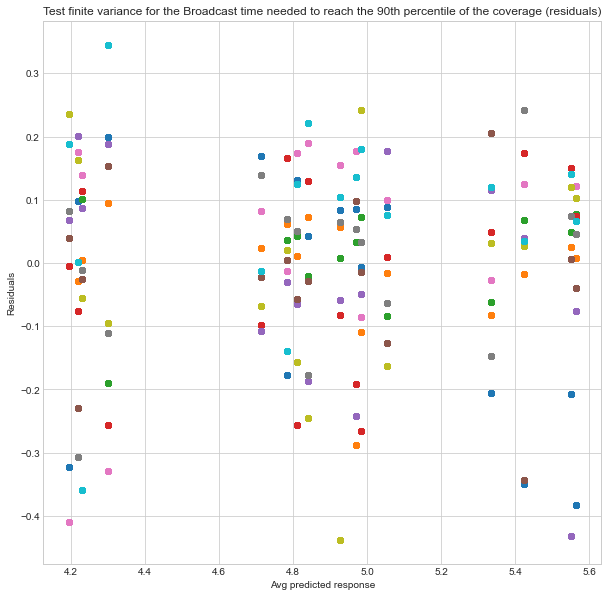

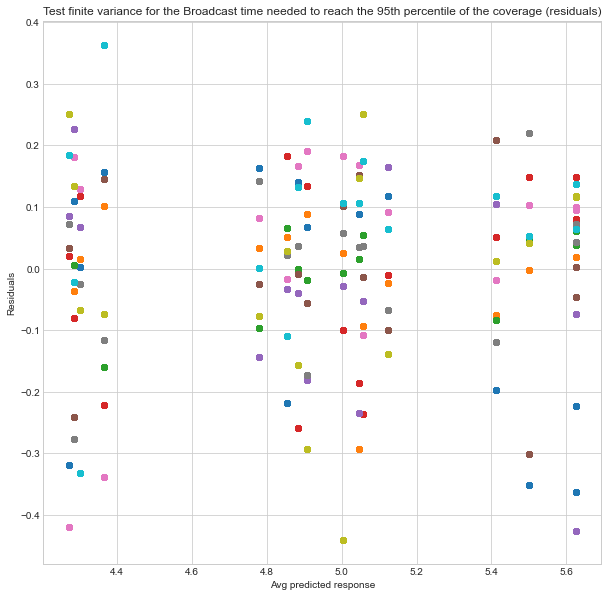

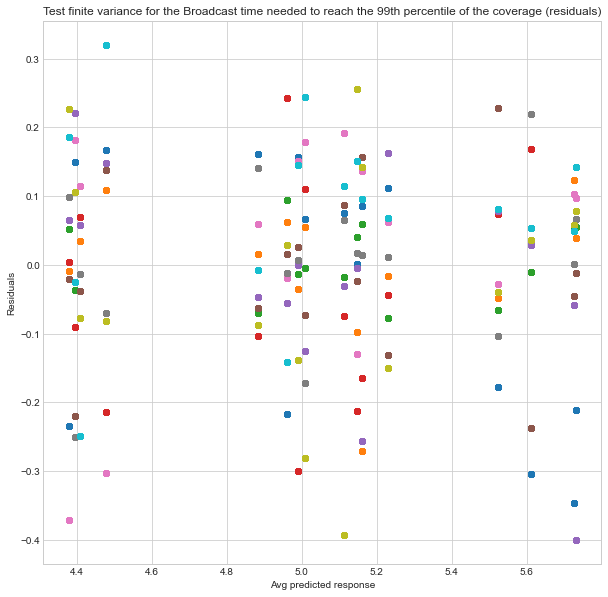

In [14]:
for varname, vardesc in residualNames:
    y = []
    x = []
    scalars_wide.sort_values([varname + 'Mean', 'repetition'], inplace=True)
    for _, row in scalars_wide.iterrows():
        config = row['config']
        if config not in configsShown:
            continue
        x.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Mean'].values.tolist())
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test finite variance for the " + vardesc)
    plt.xlabel("Avg predicted response")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-variance.png')
    plt.show()

### Notes in finite variance test

We have an increasing step on left of the collision plot and a decreasing step on the right of the message plot, but they are only steps, there isn't a trend in the residuals. As in the high density scenario, for the broadcast time we applied a logarithmic transformation of the predicted variable.

(percentage of covered users ignored)